In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
import networkx as nx
import datetime as dt
import random
import pickle
import math
import csv
import os

%matplotlib inline

ModuleNotFoundError: No module named 'seaborn'

### Visualizations & plots

In [10]:
home_dir = os.path.expanduser("~")
code_dir = os.path.join(home_dir,"Developer","GitHub","endogenous-growth")
work_dir = os.path.join(home_dir,"Documents","Research","Growth")
figs_dir = os.path.join(code_dir,"figures")

In [3]:
from utils import infomap_compression

### Endogenous growth -- network visualizations

In [5]:
def plot_networks(G_list,G_name,G_run):
        
    N = G_list[-1].number_of_nodes()
    m = G_list[0].number_of_nodes()
    
    # initilize layout position list
    pos = nx.kamada_kawai_layout(G_list[0])
    pos_list = [pos] * m
    # now loop through the added nodes
    for node in range(m,len(G_list)):
        G = G_list[node]
        # get the new node into position
        tmp = nx.spring_layout(G, pos=pos, fixed=pos.keys())
        pos[max(G.nodes)] = tmp[max(G.nodes)]
        # get the new layout
        pos = nx.kamada_kawai_layout(G, pos=pos)
        pos_list.append(pos)
        
    # COLORING
    age_frac = [i/N for i in range(N)]
    node_ages = {i:1/N for i in range(m)}
    # now loop through the added nodes
    for node in range(m,len(G_list)):
        G = G_list[node]
        node_ages[max(G.nodes)] = age_frac[node]

    # MAKE PLOTS
    for i, G in enumerate(G_list):

        # initialize figure
        fig, ax = plt.subplots(1, 1, dpi=200, figsize=(4.5,4))

        # layout by network 
        pos = pos_list[i]

        # color by node age
        node_age = [node_ages[node] for node in G.nodes()]

        # size by pagerank
        pr = nx.pagerank(G, alpha=0.95, max_iter=500)
        pr_max = max(pr.values())
        pr_rel = [pr[node]/pr_max for node in G.nodes()]    

        # draw network
        nx.draw_networkx_nodes(G, pos, node_size=[10+200*pr for pr in pr_rel], node_color=node_age, linewidths=1.5,
                            edgecolors='#333333', cmap='BuPu', ax=ax)
        nx.draw_networkx_edges(G, pos, edge_color='#999999', ax=ax, width=2, alpha=0.6)
        ax.set_axis_off()

        # Create a colorbar
        cmap = plt.colormaps['BuPu']
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax = i))
        sm.set_array([])
        plt.colorbar(sm, ax=ax)

        plt.savefig(os.path.join(code_dir,"networks",G_name,"jpeg_"+str(G_run),"N_"+str(G.number_of_nodes())+".jpeg"), bbox_inches='tight', dpi=300)
        plt.savefig(os.path.join(code_dir,"networks",G_name,"pdfs_"+str(G_run),"N_"+str(G.number_of_nodes())+".pdf"), bbox_inches='tight')
        plt.close()


In [6]:
# DEFINE NETWORKS
runs = [0]
gammas = ["rnd",0,1,2,3,4,5,6,7,8,9,"inf"]

m = 3
alpha = 0.95

for i in runs:
    for gamma in gammas:
        
        network = "_".join(["i1o1","m"+str(m),"a"+str(alpha),"g"+str(gamma)])

        # LOAD RUN
        with open(os.path.join(code_dir,"networks",network,"run_"+str(i)+'.pkl'), 'rb') as f:
            run = pickle.load(f)

        # UNPACK
        networks = run.networks
        
        # READY OUTPUT DIRECTORY
        os.mkdir(os.path.join(code_dir,"networks",network,"pdfs_"+str(i)))
        os.mkdir(os.path.join(code_dir,"networks",network,"jpeg_"+str(i)))

        # PLOT NETWORKS
        plot_networks(networks,network,i)


FileExistsError: [Errno 17] File exists: '/Users/carolina.mattsson/Developer/GitHub/endogenous-growth/networks/i1o1_m3_a0.95_grnd/pdfs_0'

### Path dependence -- node trajectories

In [5]:
# DEFINE NETWORKS
runs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
gammas = ["rnd",0,1,2,3,4,5,6,7,8,9]

m = 3
alpha = 0.95
N = 100

i_s = [10,20,30,40,50,60,70,80,90] # nodes entering at step i

# NORMALIZED RANK OF NODES i
ranks = {}
ranks_avg = {}
scores = {}
scores_avg = {}

for gamma in gammas:

    # STORE OUTPUT
    ranks[gamma] = {}
    ranks_avg[gamma] = {} 
    scores[gamma] = {}
    scores_avg[gamma] = {}

    for i in i_s:

        # STORE OUTPUT
        ranks[gamma][i] = [] 
        scores[gamma][i] = [] 
        
        for run in runs:
            # DEFINE NETWORK
            network = "_".join(["i1o1","m"+str(m),"a"+str(alpha),"g"+str(gamma)])

            # LOAD RUN
            with open(os.path.join(code_dir,"networks",network,"run_"+str(run)+'.pkl'), 'rb') as f:
                model = pickle.load(f)

            # UNPACK
            networks = model.networks
            
            # IDENTIFY NODE i
            n_i = max(networks[i-1].nodes())

            # GET SCORES
            score = [G.nodes[n_i]['score'] for G in networks[i-1:]]
            scores[gamma][i].append(np.array(score))

            # GET RANKS
            valuess = [nx.get_node_attributes(G, 'score') for G in networks[i-1:]]
            rankings = [{node: rank for rank, node in enumerate(sorted(values, key=values.get))} for values in valuess]
            rank = [ranking[n_i]/(i+j-1) for j, ranking in enumerate(rankings)]
            ranks[gamma][i].append(np.array(rank))
                
        # GET AVERAGE RANKS
        ranks_avg[gamma][i] = np.zeros(len(ranks[gamma][i][0]))
        for run in runs:
            ranks_avg[gamma][i] = ranks_avg[gamma][i] + ranks[gamma][i][run]
        ranks_avg[gamma][i] = ranks_avg[gamma][i]/len(runs)

        # GET AVERAGE SCORES
        scores_avg[gamma][i] = np.zeros(len(scores[gamma][i][0]))
        for run in runs:
            scores_avg[gamma][i] = scores_avg[gamma][i] + scores[gamma][i][run]
        scores_avg[gamma][i] = scores_avg[gamma][i]/len(runs)

    # READY OUTPUT DIRECTORY
    output = "_".join(["i1o1","m"+str(m),"a"+str(alpha)])
    if not os.path.exists(os.path.join(figs_dir,output)):
        os.mkdir(os.path.join(figs_dir,output))

In [16]:
# GAMMAS
plot_gammas = [0,5,8]
N=100

# Create a colorbar
cmap = plt.colormaps['BuPu'] 
colors = [cmap(i) for i in np.linspace(0.5, 1, len(i_s))]

#initialize figure
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12,4), sharex=True, sharey=True)

for c, i in enumerate(i_s):

       x = range(i,N+1)

       # Plot the instances
       for run in runs:
              ax[0].plot(x, ranks[plot_gammas[0]][i][run], linestyle='-', linewidth = 0.5, alpha=0.2, color=colors[c])
              ax[1].plot(x, ranks[plot_gammas[1]][i][run], linestyle='-', linewidth = 0.5, alpha=0.2, color=colors[c])
              ax[2].plot(x, ranks[plot_gammas[2]][i][run], linestyle='-', linewidth = 0.5, alpha=0.2, color=colors[c])

       # Plot the averages
       ax[0].plot(x, ranks_avg[plot_gammas[0]][i], linestyle='-', linewidth = 2, alpha=1, color=colors[c])
       ax[1].plot(x, ranks_avg[plot_gammas[1]][i], linestyle='-', linewidth = 2, alpha=1, color=colors[c])
       ax[2].plot(x, ranks_avg[plot_gammas[2]][i], linestyle='-', linewidth = 2, alpha=1, color=colors[c])

ax[0].set_ylim(0,1)
ax[0].set_xlim(1,N)

ax[0].set_title("Random ("+r'$\gamma$'+f' = {plot_gammas[0]})', fontsize=14)
ax[1].set_title("Strategic ("+r'$\gamma$'+f' = {plot_gammas[1]})', fontsize=14)
ax[2].set_title("Near-optimal ("+r'$\gamma$'+f' = {plot_gammas[2]})', fontsize=14)
ax[1].set_xlabel("Growth step", fontsize=12)
ax[0].set_ylabel("Rank (relative)", fontsize=12)


plt.savefig(os.path.join(figs_dir,output,"path-dependence.jpeg"), bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(figs_dir,output,"path-dependence.pdf"), bbox_inches='tight')
plt.close()

### Compressibility over time

In [ ]:
# DEFINE NETWORKS
runs = [0,1,2,3]
gammas = ["rnd",0,1,2,3,4,5,6,7,8,9,"inf"]

m = 3
alpha = 0.95
N = 100

codelengths = {}
codelengths_avg = {}

for gamma in gammas:
    
    # STORE OUTPUT
    codelengths[gamma] = [] 
    
    for i in runs:
        # DEFINE NETWORK
        network = "_".join(["i1o1","m"+str(m),"a"+str(alpha),"g"+str(gamma)])

        # LOAD RUN
        with open(os.path.join(code_dir,"networks",network,"run_"+str(i)+'.pkl'), 'rb') as f:
            run = pickle.load(f)

        # UNPACK
        networks = run.networks
        
        # GET COMPRESSION
        codelength = [infomap_compression(G) for G in networks]
        codelengths[gamma].append(np.array(codelength))
            
    # GET AVERAGE CODELENGTH
    codelengths_avg[gamma] = np.zeros(len(codelengths[gamma][0]))
    for i in runs:
        codelengths_avg[gamma] = codelengths_avg[gamma] + codelengths[gamma][i]
    codelengths_avg[gamma] = codelengths_avg[gamma]/len(runs)

    # READY OUTPUT DIRECTORY
    output = "_".join(["i1o1","m"+str(m),"a"+str(alpha)])
    if not os.path.exists(os.path.join(figs_dir,output)):
        os.mkdir(os.path.join(figs_dir,output))

NameError: name 'codelengths' is not defined

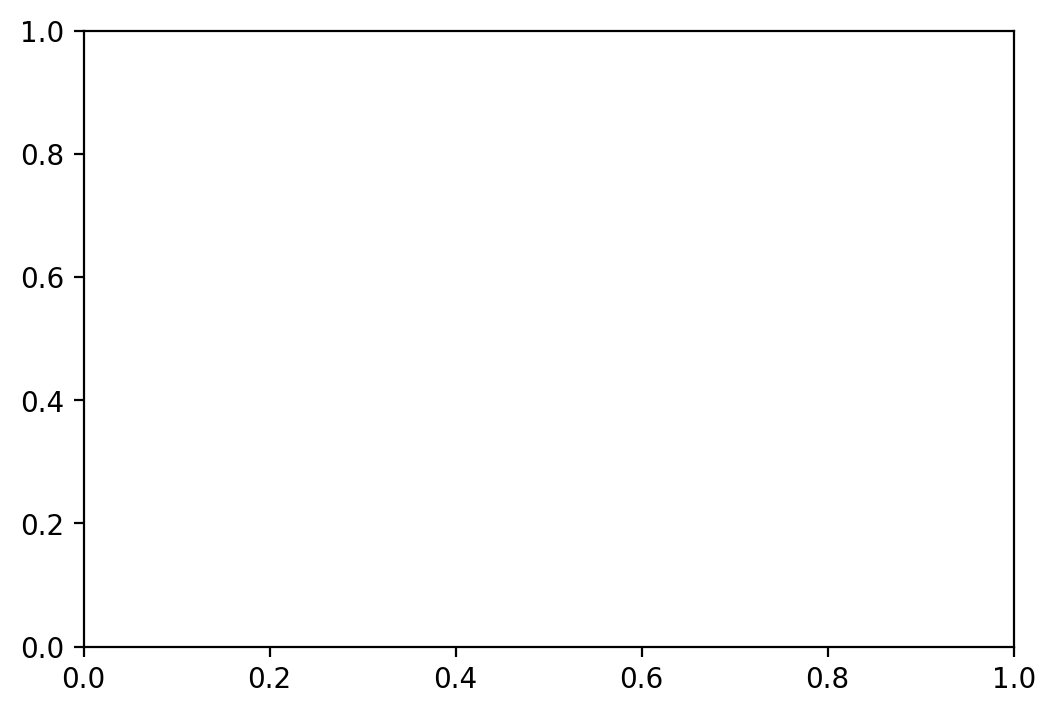

In [11]:
pwr_colors = ["#dddddd","#dddddd","#cccccc","#bbbbbb","#aaaaaa","#999999",
       "#888888","#777777","#666666","#555555","#444444","#444444"]

avg_colors = ["#CDB1D5","#CDB1D5","#C1A5C9","#B69ABE","#B69ABE","#B384C0",
       "#94789C","#896D91","#7D6185","#72567A","#674B6F","#674B6F"]

hgl_colors = ["#73b739","#ac58c4","#cc417a","#4aa98c","#ce4933","#5ba5d7",
       "#d58134","#676fc6","#bfaf46","#c47ab4","#647e36","#c36665","#a77c43","#5dba6a",]+["#e6e6e6"]*200

#initialize figure
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(6,4))

# get network size
x = range(1,N+1)

# plot
avg_powers = []
avg_labels = []
# Plot the instances
for pwr in reversed(gammas):
    for run in codelengths[pwr]:
        ax.plot(x, run, linestyle='-', linewidth = 1, alpha=0.2, color=pwr_colors[gammas.index(pwr)])
# Plot the average
for pwr in reversed(gammas):
    avg_power, = ax.plot(x, codelengths_avg[pwr], linestyle='-.', alpha=1, color=avg_colors[gammas.index(pwr)])
    avg_powers.append(avg_power)
    avg_labels.append('PR^'+str(pwr))

ax.set_title("PageRank 'alpha': "+str(alpha), fontsize=14)
ax.set_xlabel("Number of nodes", fontsize=12)
ax.set_ylabel("Compression", fontsize=12)
ax.legend(avg_powers, avg_labels, loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(os.path.join(figs_dir,output,"codelengths.jpeg"), bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(figs_dir,output,"codelengths.pdf"), bbox_inches='tight')
plt.close()

### NOW FROM HERE
* degree distribution
* creative destruction

### Plot --- pagerank by ID

In [ ]:
#for initial in [2,4,6,8]:
#for sample in [0.7,0.8,0.9]:
for jumps in [0.85,0.9,0.95]:

    # DEFINE NETWORK
    prefix = ''
    nodes = 100
    links = 1
    initial = 6
    sample = 0.8
    #jumps = 0.95

    pwrs = [8]
    runs = 10

    pwr_pageranks = {}
    ser_pageranks = {}

    for pwr in pwrs:

        # STORE OUTPUT
        pwr_pageranks[pwr] = {} 

        for run in range(runs):
            # DEFINE NETWORK
            network = prefix+"_".join(["N"+str(nodes),
                                       "m"+str(links),
                                       "k"+str(pwr),
                                       "m0"+str(initial),
                                       "x"+str(sample),
                                       "a"+str(jumps)])

            # LOAD NETWORK
            with open("../nets/"+network+"/"+str(run)+".pickle", 'rb') as netfile:
                G_list = pickle.load(netfile)

            # GET PAGERANKS
            pageranks = [nx.pagerank(G, alpha=0.95, max_iter=500) for G in G_list[:(min(nodes,50)-initial)]]
            pwr_pageranks[pwr][run] = pageranks

        # GET PAGERANK TIMESERIES
        ser_pageranks[pwr] = {}
        for run in range(runs):
            timesteps = len(pwr_pageranks[pwr][run])
            ser_pageranks[pwr][run] = np.zeros((min(nodes,50),timesteps))
            for timestep in range(timesteps):
                for node in pwr_pageranks[pwr][run][timestep]:
                    ser_pageranks[pwr][run][node][timestep] = pwr_pageranks[pwr][run][timestep][node]

        # SET COLORMAPPING
        viridis = cm.get_cmap('viridis', min(nodes,50))

        #initialize figure
        fig, ax = plt.subplots(1, 1, dpi=200, figsize=(4,4))

        # get network size
        x = np.array(range(initial,min(nodes,50)))

        # plot
        for node in range(min(nodes,50)):
            for run in ser_pageranks[pwr]:
                mask = np.isfinite(1/ser_pageranks[pwr][run][node])
                ax.plot(x[mask], ser_pageranks[pwr][run][node][mask], 
                        linestyle='-', linewidth = 1, alpha=0.2, color=viridis.colors[node])

        ax.set_title("PageRank 'alpha': "+str(jumps), fontsize=12)                
        ax.set_xlabel("Number of nodes", fontsize=12)
        ax.set_ylabel("PageRank", fontsize=12)

        plt.savefig("../figs/pagerank_"+network+"_a.png", bbox_inches='tight', dpi=425)
        plt.savefig("../figs/pagerank_"+network+"_a.pdf", bbox_inches='tight')
        plt.close()

/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
# get colormapping
viridis = cm.get_cmap('viridis', 50)

for pwr in ser_pageranks:

    #initialize figure
    fig, ax = plt.subplots(1, 1, dpi=200, figsize=(4,4))

    # get network size
    x = np.array(range(6,51))

    # plot
    for node in range(50):
        for run in ser_pageranks[pwr]:
            mask = np.isfinite(1/ser_pageranks[pwr][run][node])
            ax.plot(x[mask], ser_pageranks[pwr][run][node][mask], 
                    linestyle='-', linewidth = 1, alpha=0.2, color=viridis.colors[node])
    
    ax.set_xlabel("Number of nodes", fontsize=12)
    ax.set_ylabel("PageRank", fontsize=12)
    ax.set_ylim(0,0.28)

    plt.savefig("../figs/pagerank"+str(pwr)+".png", bbox_inches='tight', dpi=425)
    plt.savefig("../figs/pagerank"+str(pwr)+".pdf", bbox_inches='tight')
    plt.close()

/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


In [ ]:
# get colormapping
viridis = cm.get_cmap('viridis', 50)

#initialize figure
fig, ax = plt.subplots(1, 2, dpi=200, figsize=(10,4.5))

# get network size
x = np.array(range(6,50))

# plot 2
pwr = 2
for node in range(50):
    for run in ser_pageranks[pwr]:
        mask = np.isfinite(1/ser_pageranks[pwr][run][node])
        ax[0].plot(x[mask], ser_pageranks[pwr][run][node][mask], 
                linestyle='-', linewidth = 1, alpha=0.2, color=viridis.colors[node])

ax[0].set_title('Pagerank dynamics, power=2')
ax[0].set_xlabel("Number of nodes", fontsize=12)
ax[0].set_ylabel("PageRank", fontsize=12)

# plot 7
pwr = 8
for node in range(50):
    for run in ser_pageranks[pwr]:
        mask = np.isfinite(1/ser_pageranks[pwr][run][node])
        ax[1].plot(x[mask], ser_pageranks[pwr][run][node][mask], 
                linestyle='-', linewidth = 1, alpha=0.2, color=viridis.colors[node])

ax[1].set_title('Pagerank dynamics, power=8')
ax[1].set_xlabel("Number of nodes", fontsize=12)

plt.savefig("../figs/pagerank_pwr.png", bbox_inches='tight', dpi=425)
plt.savefig("../figs/pagerank_pwr.pdf", bbox_inches='tight')
plt.close()

/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


### Graveyard

In [ ]:
comcols = ["#73b739","#ac58c4","#5dba6a","#cc417a","#4aa98c","#ce4933","#5ba5d7",
       "#d58134","#676fc6","#bfaf46","#c47ab4","#647e36","#c36665","#a77c43"]+["#e6e6e6"]*200

for node in range(n_added):
    # initialize atributes
    G = G_list[node]
    
    # color by community
    partition = community.best_partition(nx.Graph(G))
    col = [comcols[com] for com in partition.values()]

    # size by pagerank
    pr = nx.pagerank(G, alpha=0.95, max_iter=500)
    pr_max = max(pr.values())
    big = [10+200*pr[node]/pr_max for node in G.nodes()]    
    
    # compute degree distribution
    degs = np.array(list(dict(G.degree()).values()))
    x, y = plot_degree(degs, number_of_bins=12)
    
    # plot each frame
    for i in range(frames):
        # initialize plot
        fig, ax = plt.subplots(1, 2, dpi=200, figsize=(10,4.5))

        # get position mapping
        pos = pos_list[node*frames+i]
        
        # draw network
        nx.draw_networkx_nodes(G, pos, node_size=big, node_color=col, linewidths=1.5,
                               edgecolors='#333333', ax=ax[0])
        nx.draw_networkx_edges(G, pos, edge_color='#999999', ax=ax[0], width=2, alpha=0.6)
        ax[0].set_xlim(minx, maxx)
        ax[0].set_ylim(miny, maxy)
        ax[0].set_axis_off()


        ax[1].plot(x, y, marker='o', linestyle='', markersize=8,
                   markeredgewidth=0, alpha=0.8, color='#333333')
        ax[1].set_xlabel("$k$", fontsize=16)
        ax[1].set_ylabel("$P(k)$", fontsize=16)
        ax[1].grid(linestyle='-', linewidth=2.5, alpha=0.3, color='#999999')
        ax[1].set_yscale('log')


        plt.savefig("../figs/pngs/economy_n"+str(node)+"_f"+str(i)+".png", bbox_inches='tight', dpi=425)
        #plt.savefig("../figs/pdfs/economy_n"+str(node)+"_f"+str(i)+".pdf", bbox_inches='tight')
        plt.close(fig)

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:789: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:789: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [ ]:
comm_prev = communities[27]
comm_list = [comm_prev]
comm_init = communities[28]
comm_prev_cnt = Counter(comm_prev.values())
print(comm_prev_cnt)
comm_init_cnt = Counter(comm_init.values())
print(comm_init_cnt)
comm_overlap = Counter()
for node in comm_prev:
    comm_overlap[(comm_prev[node],comm_init[node])] += 1
print(comm_overlap.most_common())
comm_map = {}
# get the most common matching between communities
for comm_pair, overlap in comm_overlap.most_common():
    comm_exist, comm_new = comm_pair
    # keep the largest overlaps between distinct communities
    if comm_exist in comm_prev_cnt and comm_new in comm_init_cnt:
        comm_exist_size = comm_prev_cnt.pop(comm_exist)
        comm_new_size   = comm_init_cnt.pop(comm_new)
        # record as a dictionary mapping
        comm_map[comm_new] = comm_exist
        
# give new communities new index values
needs_index = [comm for comm, size in sorted(comm_init_cnt.items(), key=lambda item: item[1])]
idx = 0
while 0 > len(needs_index):
    if idx not in comm_map and idx not in comm_prev_cnt:
        comm_new = needs_index.pop()
        comm_map[comm_new] = idx
    idx+=1

comm_map

Counter({0: 11, 1: 8, 4: 6, 2: 5, 3: 3})
Counter({0: 11, 1: 9, 4: 6, 2: 5, 3: 3})
[((0, 0), 11), ((1, 1), 8), ((2, 2), 5), ((4, 4), 5), ((3, 3), 3), ((4, 1), 1)]


{0: 0, 1: 1, 2: 2, 4: 4, 3: 3}